In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import optuna
import shap

In [5]:
class SMOTETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.smote = SMOTE(random_state=self.random_state)

    def fit_resample(self, X, y):
        return self.smote.fit_resample(X, y)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

In [47]:
# Load the data
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

# Impute missing ages with median
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

# Impute missing embarkments
most_frequent_embarked = train_data['Embarked'].mode()[0]
train_data['Embarked'] = train_data['Embarked'].fillna(most_frequent_embarked)
test_data['Embarked'] = test_data['Embarked'].fillna(most_frequent_embarked)

# Combine train and test for preprocessing
all_data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

In [54]:
# Feature Engineering
# Extract titles from names
all_data['Title'] = all_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

# Name-related features
all_data['NameLength'] = all_data['Name'].str.len()
surname_freq = all_data['Name'].str.split(',').str[0].value_counts()
all_data['SurnameFreq'] = all_data['Name'].str.split(',').str[0].map(surname_freq)

# Create family size feature
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

# Create is_alone feature
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = 1

# Extract deck from cabin
all_data['Deck'] = all_data['Cabin'].str.slice(0,1)
all_data['Deck'] = all_data['Deck'].fillna('U')

# Bin age
all_data['AgeBin'] = pd.cut(all_data['Age'], bins=[0, 12, 20, 40, 60, 100], labels=['Child', 'Teen', 'Adult', 'Senior', 'Elderly'])

# Fare-related features
all_data['FareBin'] = pd.qcut(all_data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
all_data['FarePerPerson'] = all_data['Fare'] / all_data['FamilySize']

# Create interaction features
all_data['Age*Class'] = all_data['Age'] * all_data['Pclass']
all_data['Fare*Class'] = all_data['Fare'] * all_data['Pclass']
all_data['Sex*Pclass'] = all_data['Sex'].astype(str) + '_' + all_data['Pclass'].astype(str)
all_data['Age*Sex'] = all_data['AgeBin'].astype(str) + '_' + all_data['Sex'].astype(str)

# Derived features
all_data['FamilyType'] = pd.cut(all_data['FamilySize'], bins=[0, 1, 4, 20], labels=['Single', 'Small Family', 'Large Family'])
all_data['Title*Pclass'] = all_data['Title'] + '_' + all_data['Pclass'].astype(str)

# Cabin-related features
def extract_cabin_number(cabin):
    if pd.isna(cabin):
        return np.nan
    match = re.search(r'(\d+)', cabin)
    return float(match.group(1)) if match else np.nan

all_data['CabinNumber'] = all_data['Cabin'].apply(extract_cabin_number)
all_data['HasCabin'] = (~all_data['Cabin'].isna()).astype(int)
all_data['MultipleCabins'] = (all_data['Cabin'].str.count(' ') > 0).fillna(0).astype(int)

# Feature Selection
numeric_features = ['Age', 'Fare', 'FamilySize', 'NameLength', 'SurnameFreq', 'FarePerPerson']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin', 'IsAlone', 'Age*Class', 'Fare*Class', 'Sex*Pclass', 'Age*Sex', 'FamilyType', 'Title*Pclass']

In [55]:


# Split back into train and test
train_data = all_data[all_data['Survived'].notna()].copy()
test_data = all_data[all_data['Survived'].isna()].copy()

X = train_data[numeric_features + categorical_features]
y = train_data['Survived']

X.head(5)

,Age,Fare,FamilySize,NameLength,SurnameFreq,FarePerPerson,Pclass,Sex,Embarked,Title,Deck,AgeBin,FareBin,IsAlone,Age*Class,Fare*Class,Sex*Pclass,Age*Sex,FamilyType,Title*Pclass
0,22.0,7.2500,2,23,2,3.62500,3,male,S,Mr,U,Adult,Low,0,66.0,21.7500,male_3,Adult_male,Small Family,Mr_3
1,38.0,71.2833,2,51,2,35.64165,1,female,C,Mrs,C,Adult,Very High,0,38.0,71.2833,female_1,Adult_female,Small Family,Mrs_1
2,26.0,7.9250,1,22,1,7.92500,3,female,S,Miss,U,Adult,Medium,1,78.0,23.7750,female_3,Adult_female,Single,Miss_3
3,35.0,53.1000,2,44,2,26.55000,1,female,S,Mrs,C,Adult,Very High,0,35.0,53.1000,female_1,Adult_female,Small Family,Mrs_1
4,35.0,8.0500,1,24,2,8.05000,3,male,S,Mr,U,Adult,Medium,1,105.0,24.1500,male_3,Adult_male,Single,Mr_3


In [22]:
# Encode categorical variables
categorical_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = pd.DataFrame(categorical_encoder.fit_transform(X[categorical_features]))
X_encoded.columns = categorical_encoder.get_feature_names_out(categorical_features)

# Combine with numeric features
X_numeric = X[numeric_features].reset_index(drop=True)
X_preprocessed = pd.concat([X_numeric, X_encoded], axis=1)

In [11]:
# Perform mutual information analysis
mi_scores = mutual_info_classif(X_preprocessed, y)
mi_scores = pd.Series(mi_scores, index=X_preprocessed.columns)
mi_scores = mi_scores.sort_values(ascending=False)

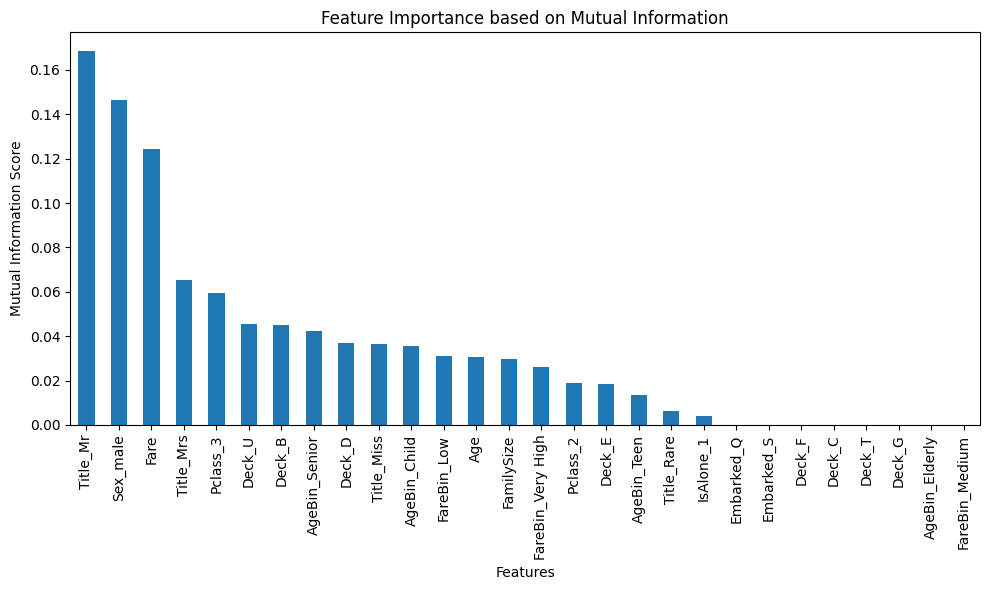

In [19]:
# Plot mutual information scores
plt.figure(figsize=(10, 6))
mi_scores.plot.bar()
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.tight_layout()
plt.show()

In [46]:
# Select top K features
k_best_features = SelectKBest(mutual_info_classif, k=15)
X_new = k_best_features.fit_transform(X_preprocessed, y)
selected_feature_names = X_preprocessed.columns[k_best_features.get_support()]

print("Top 15 features selected:", selected_feature_names)

ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [45]:
# Expanded Feature Engineering
# Cabin-related features
def extract_cabin_number(cabin):
    if pd.isna(cabin):
        return np.nan
    match = re.search(r'(\d+)', cabin)
    return float(match.group(1)) if match else np.nan

all_data['CabinNumber'] = all_data['Cabin'].apply(extract_cabin_number)
all_data['HasCabin'] = (~all_data['Cabin'].isna()).astype(int)
all_data['MultipleCabins'] = (all_data['Cabin'].str.count(' ') > 0).fillna(0).astype(int)

# Interaction features
all_data['Sex*Pclass'] = all_data['Sex'].astype(str) + '_' + all_data['Pclass'].astype(str)
all_data['Age*Sex'] = all_data['AgeBin'].astype(str) + '_' + all_data['Sex'].astype(str)

# Derived features
all_data['FamilyType'] = pd.cut(all_data['FamilySize'], bins=[0, 1, 4, 20], labels=['Single', 'Small Family', 'Large Family'])
all_data['Title*Pclass'] = all_data['Title'] + '_' + all_data['Pclass'].astype(str)

# Fare-related features
all_data['FarePerPerson'] = all_data['Fare'] / all_data['FamilySize']

# Name-related features
all_data['NameLength'] = all_data['Name'].str.len()
surname_freq = all_data['Name'].str.split(',').str[0].value_counts()
all_data['SurnameFreq'] = all_data['Name'].str.split(',').str[0].map(surname_freq)

# Update feature lists
numeric_features = list(dict.fromkeys(numeric_features + ['FarePerPerson', 'NameLength', 'SurnameFreq', 'CabinNumber']))
categorical_features = list(dict.fromkeys(categorical_features + ['Sex*Pclass', 'Age*Sex', 'FamilyType', 'Title*Pclass', 'HasCabin', 'MultipleCabins', 'Deck']))

print("Updated numeric features:", numeric_features)
print("Updated categorical features:", categorical_features)

# Print some statistics about the new features
print("\nCabin-related feature statistics:")
print(all_data[['CabinNumber', 'HasCabin', 'MultipleCabins', 'Deck']].describe())
print("\nPercentage of missing CabinNumbers:", all_data['CabinNumber'].isna().mean() * 100)

Updated numeric features: ['Age', 'Fare', 'FamilySize', 'FarePerPerson', 'NameLength', 'SurnameFreq', 'CabinNumber']
Updated categorical features: ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeBin', 'FareBin', 'IsAlone', 'Sex*Pclass', 'Age*Sex', 'FamilyType', 'Title*Pclass', 'MultipleCabins', 'HasCabin']

Cabin-related feature statistics:
       CabinNumber     HasCabin  MultipleCabins
count   289.000000  1309.000000     1309.000000
mean     49.615917     0.225363        0.031322
std      34.018600     0.417981        0.174252
min       2.000000     0.000000        0.000000
25%      23.000000     0.000000        0.000000
50%      43.000000     0.000000        0.000000
75%      73.000000     0.000000        0.000000
max     148.000000     1.000000        1.000000

Percentage of missing CabinNumbers: 77.92207792207793


In [44]:
# Split back into train and test
train_data = all_data[all_data['Survived'].notna()].copy()
test_data = all_data[all_data['Survived'].isna()].copy()

X = train_data[numeric_features + categorical_features]
y = train_data['Survived']

X.head(5)

,Age,Fare,FamilySize,FarePerPerson,NameLength,SurnameFreq,CabinNumber,Pclass,Sex,Embarked,...,Deck,AgeBin,FareBin,IsAlone,Sex*Pclass,Age*Sex,FamilyType,Title*Pclass,MultipleCabins,HasCabin
0,22.0,7.2500,2,3.62500,23,2,NaN,3,male,S,...,U,Adult,Low,0,male_3,Adult_male,Small Family,Mr_3,0,0
1,38.0,71.2833,2,35.64165,51,2,85.0,1,female,C,...,C,Adult,Very High,0,female_1,Adult_female,Small Family,Mrs_1,0,1
2,26.0,7.9250,1,7.92500,22,1,NaN,3,female,S,...,U,Adult,Medium,1,female_3,Adult_female,Single,Miss_3,0,0
3,35.0,53.1000,2,26.55000,44,2,123.0,1,female,S,...,C,Adult,Very High,0,female_1,Adult_female,Small Family,Mrs_1,0,1
4,35.0,8.0500,1,8.05000,24,2,NaN,3,male,S,...,U,Adult,Medium,1,male_3,Adult_male,Single,Mr_3,0,0


In [41]:
# Encode categorical variables of expanded features
categorical_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = pd.DataFrame(categorical_encoder.fit_transform(X[categorical_features]))
X_encoded.columns = categorical_encoder.get_feature_names_out(categorical_features)

# Combine with expanded numeric features
X_numeric = X[numeric_features].reset_index(drop=True)
X_preprocessed = pd.concat([X_numeric, X_encoded], axis=1)

# Perform mutual information analysis
mi_scores = mutual_info_classif(X_preprocessed, y)
mi_scores = pd.Series(mi_scores, index=X_preprocessed.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Plot mutual information scores
plt.figure(figsize=(10, 6))
mi_scores.plot.bar()
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.tight_layout()
plt.show()

ValueError: Input X contains NaN.